In [67]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# display images
# from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy


In [68]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [69]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [70]:
def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [71]:
class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG16, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [72]:
class VGG19(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG19, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_4_block(2*base_dim,4*base_dim), #256
            conv_4_block(4*base_dim,8*base_dim), #512
            conv_4_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [73]:
# device 설정
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# VGG 클래스를 인스턴스화
model = VGG19(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="Data/", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="Data/", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [75]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=100,
                                           shuffle=True, num_workers=6)

In [76]:
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=100,
                                           shuffle=True, num_workers=6)

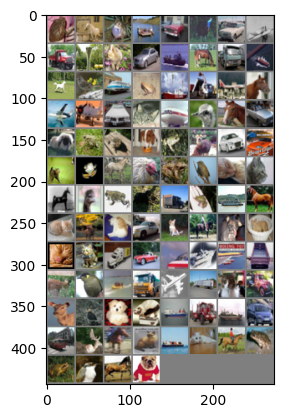

 frog horse  frog  ship   car  bird   car plane truck  bird


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
batch_size = 10

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [85]:
batch_size = 100
learning_rate = 0.001
num_epoch = 20

In [77]:
from tqdm import trange

In [78]:
import torch
print(torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

2.3.0
MPS available: True


In [79]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.3.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-14.5-arm64-arm-64bit


In [86]:
from tqdm import trange
patience = 10  # 개선되지 않는 에포크 수
best_loss = float('inf')
trigger_times = 0

loss_arr = []
for i in trange(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model(x)  # .forward()는 일반적으로 생략
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())

  5%|██▏                                         | 1/20 [01:24<26:47, 84.62s/it]

tensor(1.8964, device='mps:0', grad_fn=<NllLossBackward0>)


 10%|████▍                                       | 2/20 [02:49<25:24, 84.69s/it]

tensor(1.8763, device='mps:0', grad_fn=<NllLossBackward0>)


 15%|██████▌                                     | 3/20 [04:13<23:56, 84.49s/it]

tensor(1.6378, device='mps:0', grad_fn=<NllLossBackward0>)


 20%|████████▊                                   | 4/20 [05:37<22:29, 84.34s/it]

tensor(1.6409, device='mps:0', grad_fn=<NllLossBackward0>)


 25%|███████████                                 | 5/20 [07:01<21:04, 84.28s/it]

tensor(1.3101, device='mps:0', grad_fn=<NllLossBackward0>)


 30%|█████████████▏                              | 6/20 [08:26<19:42, 84.45s/it]

tensor(1.1364, device='mps:0', grad_fn=<NllLossBackward0>)


 35%|███████████████▍                            | 7/20 [09:51<18:17, 84.44s/it]

tensor(1.0768, device='mps:0', grad_fn=<NllLossBackward0>)


 40%|█████████████████▌                          | 8/20 [11:15<16:53, 84.47s/it]

tensor(0.9600, device='mps:0', grad_fn=<NllLossBackward0>)


 45%|███████████████████▊                        | 9/20 [12:40<15:29, 84.46s/it]

tensor(0.8297, device='mps:0', grad_fn=<NllLossBackward0>)


 50%|█████████████████████▌                     | 10/20 [14:04<14:04, 84.49s/it]

tensor(0.6746, device='mps:0', grad_fn=<NllLossBackward0>)


 55%|███████████████████████▋                   | 11/20 [15:29<12:40, 84.49s/it]

tensor(0.8800, device='mps:0', grad_fn=<NllLossBackward0>)


 60%|█████████████████████████▊                 | 12/20 [16:53<11:15, 84.47s/it]

tensor(0.8929, device='mps:0', grad_fn=<NllLossBackward0>)


 65%|███████████████████████████▉               | 13/20 [18:17<09:51, 84.47s/it]

tensor(0.5706, device='mps:0', grad_fn=<NllLossBackward0>)


 70%|██████████████████████████████             | 14/20 [19:42<08:26, 84.47s/it]

tensor(0.6961, device='mps:0', grad_fn=<NllLossBackward0>)


 75%|████████████████████████████████▎          | 15/20 [21:06<07:02, 84.47s/it]

tensor(0.5849, device='mps:0', grad_fn=<NllLossBackward0>)


 80%|██████████████████████████████████▍        | 16/20 [22:31<05:37, 84.45s/it]

tensor(0.6672, device='mps:0', grad_fn=<NllLossBackward0>)


 85%|████████████████████████████████████▌      | 17/20 [23:55<04:13, 84.42s/it]

tensor(0.8229, device='mps:0', grad_fn=<NllLossBackward0>)


 90%|██████████████████████████████████████▋    | 18/20 [25:20<02:48, 84.41s/it]

tensor(0.6005, device='mps:0', grad_fn=<NllLossBackward0>)


 95%|████████████████████████████████████████▊  | 19/20 [26:44<01:24, 84.41s/it]

tensor(0.6467, device='mps:0', grad_fn=<NllLossBackward0>)


100%|███████████████████████████████████████████| 20/20 [28:08<00:00, 84.44s/it]

tensor(0.4797, device='mps:0', grad_fn=<NllLossBackward0>)


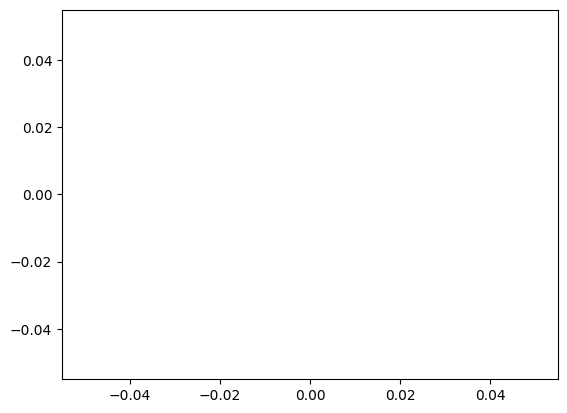

In [87]:
plt.plot(loss_arr)
plt.show()

In [88]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:

        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)


        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()

    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 75.68000030517578%


In [81]:
print(f"Using device: {device}")
print(f"Device type set in summary: {'cpu' if device == torch.device('mps') else device.type}")


Using device: mps:0
Device type set in summary: mps


In [84]:
print(device.model)

AttributeError: 'torch.device' object has no attribute 'model'